In [75]:
import cv2
import scipy
import copy
import spatialmath
from scipy.spatial.transform import Rotation
import machinevisiontoolbox as mv
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


def getcube(n):
    d_x = d_y = d_z = 1 / n
    x0 = y0 = z0 = -0.5
    x = np.arange(x0, -x0, d_x, dtype=float)
    y = np.arange(y0, -y0, d_y, dtype=float)
    z = np.arange(z0, -z0, d_z, dtype=float)
    x = np.append(x, 0.5)
    y = np.append(y, 0.5)
    z = np.append(z, 0.5)
    cube = np.stack(np.meshgrid(x, y, z))
    Q = cube.reshape(3, -1)  # cube
    Q = np.swapaxes(Q, 0, 1)
    Q = Q[(abs(Q) == 0.5).sum(axis=1) >= 2]
    ones = np.ones(Q.shape[0]).reshape(Q.shape[0], 1)
    Q = np.concatenate((Q, ones), axis=1)
    Q = np.append(np.vstack(
        (x, np.zeros_like(x), np.zeros_like(x), np.ones_like(x))).T, Q, axis=0)
    Q = np.append(np.vstack(
        (np.zeros_like(x), y, np.zeros_like(x), np.ones_like(x))).T, Q, axis=0)
    Q = np.append(np.vstack(
        (np.zeros_like(x), np.zeros_like(x), z, np.ones_like(x))).T, Q, axis=0)
    return Q


def projectpoints(K, R, t, Q, printP=False):
    Q.reshape((Q.shape[1], Q.shape[0]))
    T = np.concatenate((R, t), axis=1)
    P = K @ T
    ppsx = []
    ppsy = []
    for i in range(Q.shape[0]):
        p = Q[i, :]
        projected = P @ p.reshape(4, 1)
        if printP and (Q[i, :] == np.array([-0.5, -0.5, -0.5, 1.0])).all():
            print(projected/projected[2])
            print(P)
        ppsx.append(float(projected[0]/projected[2]))
        ppsy.append(float(projected[1]/projected[2]))
    return ppsx, ppsy


DEG2RAD = np.pi / 180

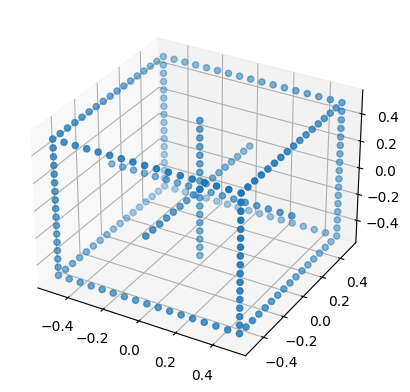

In [76]:
Q = getcube(16)
ax = plt.axes(projection='3d')
ax.scatter3D(Q[:, 0], Q[:, 1], Q[:, 2])

In [77]:
params = {
    "f": 0.008,
    "rho": 10e-6,
    "imagesize": 640,
    "pp": (320, 320),
    "name": "default perspective camera",
    "pose": spatialmath.SE3.Tz(-2.5) * spatialmath.SE3.Rx(2*DEG2RAD) * spatialmath.SE3.Ry(0*DEG2RAD) * spatialmath.SE3.Rz(3*DEG2RAD),
}
cam = mv.CentralCamera(**params)
cam, cam.K
K = cam.K
# cam rotate the camera like here : )
cam.pose = cam.pose * spatialmath.SE3.Rz(-3*DEG2RAD)
cam

           Name: default perspective camera [CentralCamera]
     pixel size: 1e-05 x 1e-05
     image size: 640 x 640
           pose: t = 0, 0, -2.5; rpy/yxz = 0°, 2°, 0°
   principal pt: [320.000 320.000]
   focal length: [0.008 0.008]

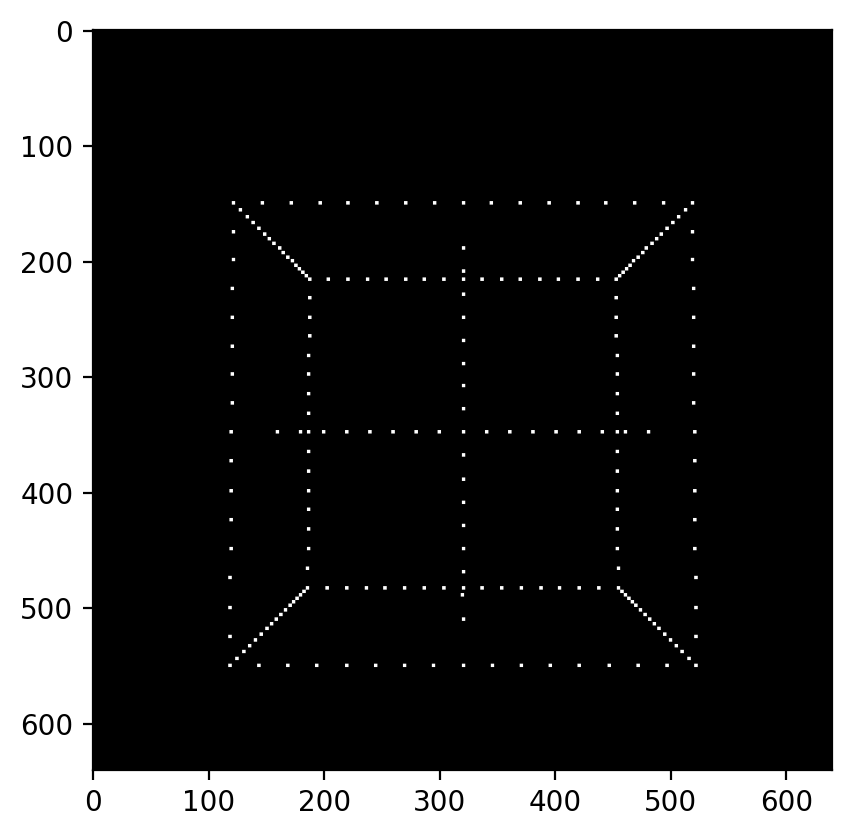

In [78]:
projected, _ = cam.project_point(Q.T[:3, :], visibility=True)
img = np.zeros((640, 640))

for i in range(projected.shape[1]):
    p = projected[:, i]
    if np.isnan(p[0]) or np.isnan(p[1]):
        continue
    u, v = int(p[1]), int(p[0])
    # img[u, v] = 255
    for j in [-1, 0, 1]:
        for k in [-1, 0, 1]:
            if u+j < 0 or u+j >= 640 or v+k < 0 or v+k >= 640:
                continue
            img[u+j, v+k] = 255

plt.figure(dpi=200)
plt.imshow(img, cmap='gray')

In [79]:

# Define the vertices of the cube
vertices = [
    [-0.5, -0.5, -0.5],  # 0
    [-0.5, -0.5,  0.5],  # 1
    [-0.5,  0.5, -0.5],  # 2
    [-0.5,  0.5,  0.5],  # 3
    [0.5, -0.5, -0.5],  # 4
    [0.5, -0.5,  0.5],  # 5
    [0.5,  0.5, -0.5],  # 6
    [0.5,  0.5,  0.5],  # 7
]

# Define the center points of each wall
centers = [
    [-0.5, 0, 0],  # Left
    [0.5, 0, 0],  # Right
    [0, -0.5, 0],  # Bottom
    [0, 0.5, 0],  # Top
    [0, 0, -0.5],  # Back
    [0, 0, 0.5],  # Front
]

In [80]:
# https://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html

# randomly select N points
N = int(Q.shape[0]*.5)
rnd_points = np.random.choice(Q.shape[0], N, replace=False)
points_3d = Q[rnd_points][:, :3]
points_3d = np.array(vertices + centers)
N = points_3d.shape[0]

cams = []
params = {
    "f": 0.008,
    "rho": 10e-6,
    "imagesize": 640,
    "pp": (320, 320),
    "name": "default perspective camera",
    "pose": spatialmath.SE3.Tz(-2.5) * spatialmath.SE3.Rx(2*DEG2RAD) * spatialmath.SE3.Ry(0*DEG2RAD) * spatialmath.SE3.Rz(3*DEG2RAD),
}
cam = mv.CentralCamera(**params)
for i in range(3):
    cams.append(copy.copy(cam))
    cam.pose = cam.pose * spatialmath.SE3.Tx(-.1)

camera_ind = np.concatenate((np.zeros(N, dtype=np.uint8), np.ones(
    N, dtype=np.uint8), np.ones(N, dtype=np.uint8)*2))

point_ind = np.concatenate((np.arange(0, N, dtype=np.uint8), np.arange(
    0, N, dtype=np.uint8), np.arange(0, N, dtype=np.uint8)))
point_ind

points_2d = []
for i in range(3):
    projected, _ = cams[i].project_point(points_3d.T, visibility=True)
    points_2d.append(np.array(projected.T))
    # points_2d.append(np.array(projected.T))
points_2d = np.concatenate(points_2d)

In [81]:
points1 = points_2d[:N]
points2 = points_2d[N:N*2]

K = cams[0].K
assert (K == cams[1].K).all()
E, mask = cv2.findEssentialMat(points1, points2, K)
retval, R, t, mask = cv2.recoverPose(E, points1, points2)
s = .1
print(R, s*t, retval)
P0 = K @ np.concatenate((np.eye(3), np.zeros((3, 1))), axis=1)
P1 = K @ np.concatenate((R, t*s), axis=1)

[[1.000 -0.000 0.000]
 [-0.000 1.000 0.000]
 [-0.000 -0.000 1.000]] [[0.100]
 [-0.000]
 [-0.000]] 14


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0085e+00                                    4.92e-01    
       1              3         2.0073e+00      1.18e-03       1.15e+00       1.19e-01    
       2              4         2.0072e+00      5.36e-05       2.30e+00       1.03e+01    
       3              5         2.0072e+00      8.17e-07       2.30e+00       5.24e-01    
       4              6         2.0072e+00      2.88e-05       5.76e-01       5.78e-02    
       5              8         2.0072e+00      3.36e-06       2.88e-01       1.05e-02    
       6              9         2.0072e+00      1.40e-07       2.88e-01       4.02e-03    
       7             10         2.0072e+00      7.41e-09       7.20e-02       2.54e-04    
       8             11         2.0072e+00      1.50e-11       1.80e-02       6.99e-05    
       9             19         2.0072e+00      4.88e-15       2.75e-07       8.38e-06    

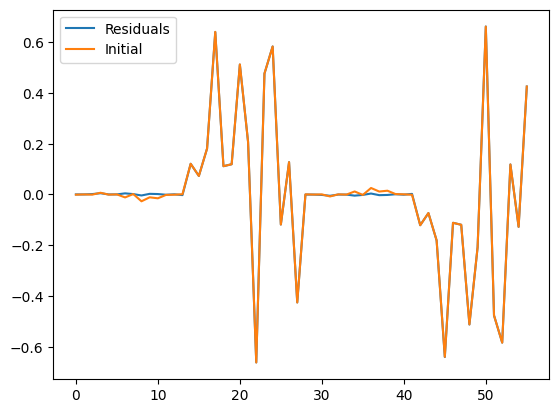

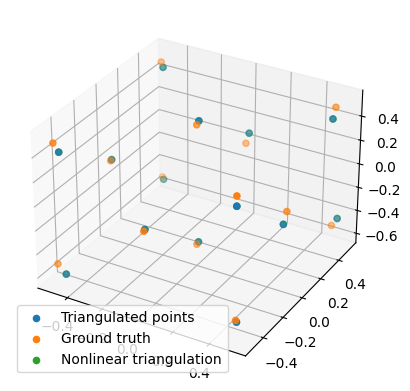

In [82]:
cam0 = cams[0]
cam1 = cams[1]
# wrong : )
# P0 = K @ np.concatenate((cam0.pose.R, cam0.pose.t.reshape((3, 1))), axis=1)
# P1 = K @ np.concatenate((cam1.pose.R, cam1.pose.t.reshape((3, 1))), axis=1)
P0 = cams[0].C()
P1 = cams[1].C()
P0[:,3:] = P0[:,3:] + np.random.rand(3,1)*.01
P1[:,3:] = P1[:,3:] + np.random.rand(3,1)*.01

# Rotation.from_euler('xyz', np.random.rand(3,1).T, degrees=True).as_matrix()

# add some noise
points1 = points1 + np.random.rand(*points1.shape)*2
points2 = points2 + np.random.rand(*points2.shape)*2

triang = cv2.triangulatePoints(P0, P1, points1.T, points2.T)

x0 = (triang/triang[3, :])
P = [P0, P1]
features = [points1.T, points2.T]
org_shape = x0.shape

# this could include feature point aptimization & and refinement of camera poses??
def compute_residuals(Qw):
    Qw = Qw.reshape(org_shape)
    R = []
    for i in range(len(P)):
        inter = P[i] @ Qw
        inter = (inter/inter[2, :])[:2]
        R.append(inter - features[i])
    R = np.array(R)
    R = R.flatten()
    return R


res = scipy.optimize.least_squares(
    compute_residuals, x0.ravel(), verbose=2)
res.x
t = res.x
plt.figure()
plt.plot(res.fun, label='Residuals')
plt.plot(compute_residuals(x0.ravel()), label='Initial')
plt.legend()
t = t.reshape(org_shape)
t /= t[3, :]

# plot 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(triang[0]/triang[3], triang[1]/triang[3],
           triang[2]/triang[3], label='Triangulated points')
ax.scatter(points_3d[:, 0], points_3d[:, 1],
           points_3d[:, 2], label='Ground truth')
ax.scatter(t[0]/t[3], t[1]/t[3], t[2]/t[3], label='Nonlinear triangulation')
ax.legend()

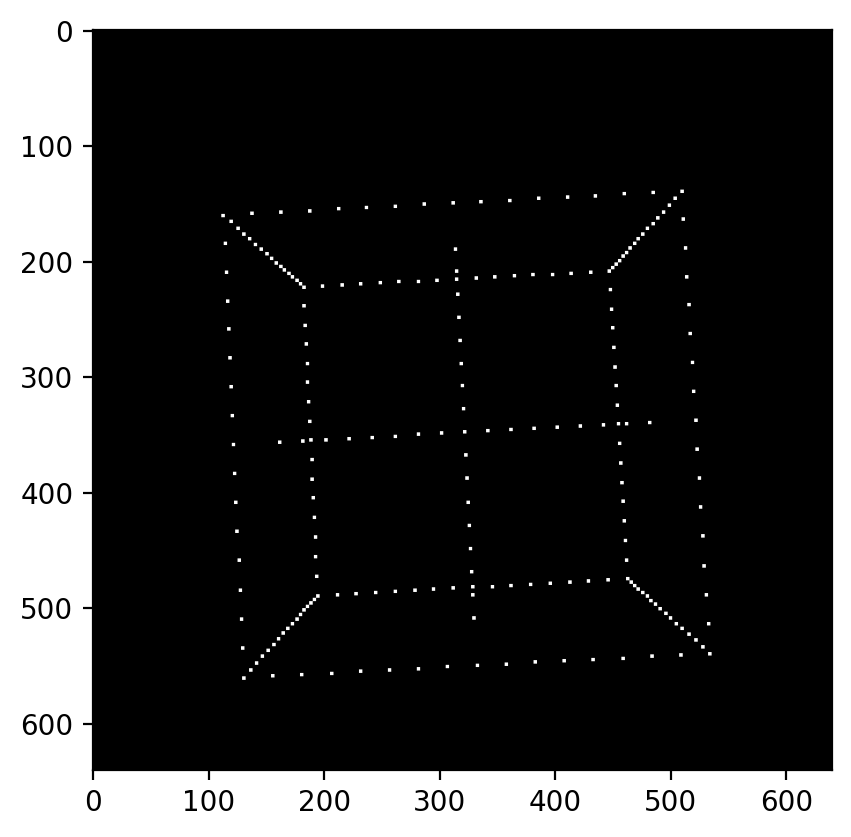

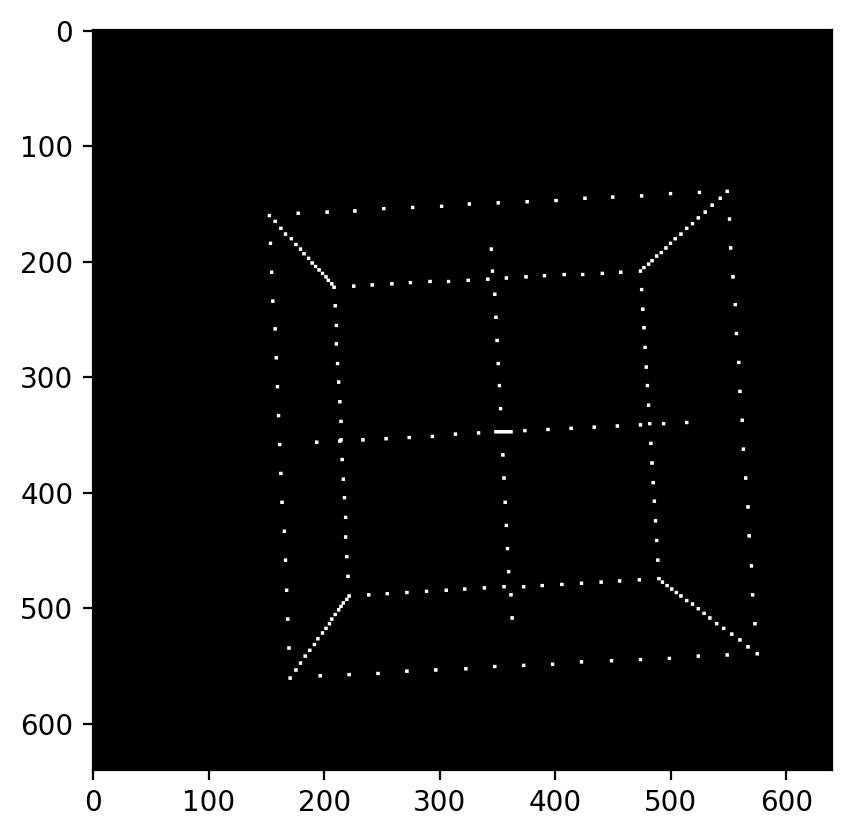

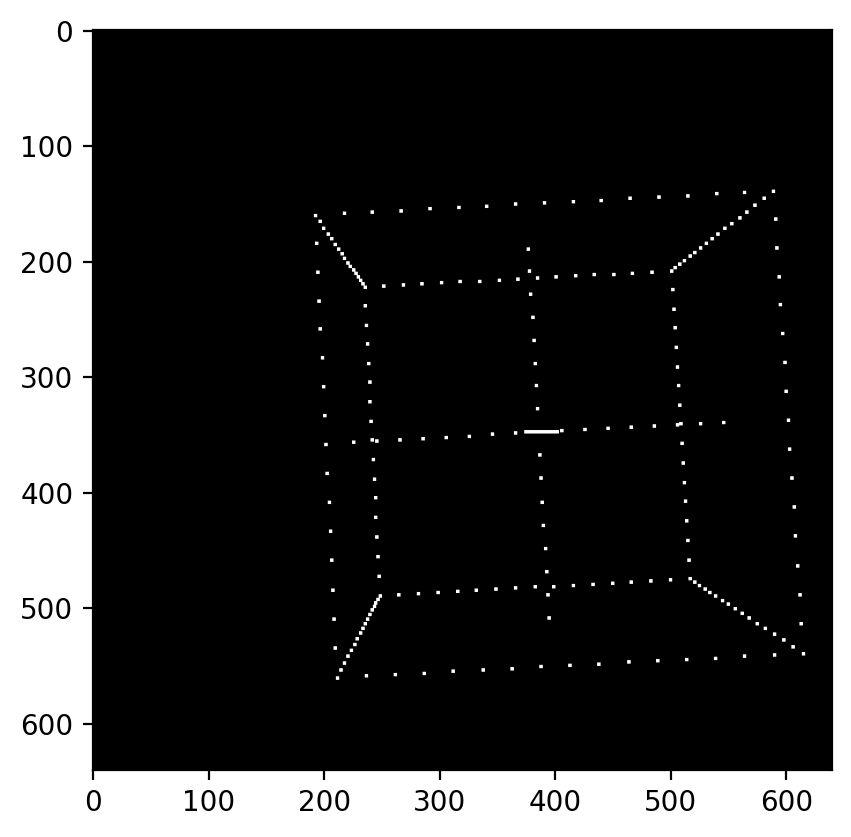

In [83]:
for cam in cams:
    projected, _ = cam.project_point(Q.T[:3, :], visibility=True)
    img = np.zeros((640, 640))

    for i in range(projected.shape[1]):
        p = projected[:, i]
        if np.isnan(p[0]) or np.isnan(p[1]):
            continue
        u, v = int(p[1]), int(p[0])
        # img[u, v] = 255
        for j in [-1, 0, 1]:
            for k in [-1, 0, 1]:
                if u+j < 0 or u+j >= 640 or v+k < 0 or v+k >= 640:
                    continue
                img[u+j, v+k] = 255

    plt.figure(dpi=200)
    plt.imshow(img, cmap='gray')

In [84]:
def fun(params, n_cameras, n_points, points_2d):
    """Compute residuals.
    `params` contains camera parameters and 3-D coordinates.
    """
    camera_params = params[:n_cameras * 6].reshape((n_cameras, 6))
    points_3d = params[n_cameras * 6:].reshape((n_points, 3))
    points_proj = []
    for i, c in enumerate(cams):
        cam_pose = camera_params[i]
        R = Rotation.from_rotvec(cam_pose[:3]).as_matrix()
        t = cam_pose[3:]
        print(R,t)
        T = np.concatenate((R, t.reshape(3, 1)), axis=1)
        T = np.concatenate((T, np.array([[0, 0, 0, 1]])), axis=0)
        projected, _ = c.project_point(
            points_3d.T, pose=spatialmath.SE3(T), visibility=True)
        points_proj.append(projected.T)
    points_proj = np.concatenate(points_proj)
    return (points_proj - points_2d).ravel()

In [85]:
points_3d

array([[-0.500, -0.500, -0.500],
       [-0.500, -0.500, 0.500],
       [-0.500, 0.500, -0.500],
       [-0.500, 0.500, 0.500],
       [0.500, -0.500, -0.500],
       [0.500, -0.500, 0.500],
       [0.500, 0.500, -0.500],
       [0.500, 0.500, 0.500],
       [-0.500, 0.000, 0.000],
       [0.500, 0.000, 0.000],
       [0.000, -0.500, 0.000],
       [0.000, 0.500, 0.000],
       [0.000, 0.000, -0.500],
       [0.000, 0.000, 0.500]])

In [86]:
camera_params = []
for c in cams:
    R = c.pose.A[:3, :3]  # c.pose.R
    # assert (c.pose.inv().A[:3,:3] == R).all()
    r = Rotation.from_matrix(R)
    rot = r.as_rotvec()
    t = c.pose.A[:3, 3]  # c.pose.t
    print(np.concatenate((rot, t)))
    camera_params.append(np.concatenate((rot, t)))

camera_params = np.concatenate(camera_params)
camera_params
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
# add noise
x0[:len(cams)*6] += np.random.randn(len(cams)*6) * .01
x0[len(cams)*6:] += np.random.randn(x0[len(cams)*6:].size) * .01
# x0[len(cams)*6:] = 0*np.abs(np.random.randn(x0[len(cams)*6:].size) * .1)

[0.035 -0.001 0.052 0.000 0.000 -2.500]
[0.035 -0.001 0.052 -0.100 -0.005 -2.500]
[0.035 -0.001 0.052 -0.200 -0.010 -2.500]


In [87]:
euler1 = Rotation.from_rotvec(x0[:3]).as_euler('xyz', degrees=True)
euler2 = Rotation.from_rotvec(camera_params[:3]).as_euler('xyz', degrees=True)
euler1, euler2

(array([1.589, -0.536, 2.816]), array([1.997, -0.105, 2.998]))

[[0.999 -0.049 -0.008]
 [0.049 0.998 -0.028]
 [0.009 0.028 1.000]] [-0.007 -0.007 -2.506]
[[0.998 -0.055 0.005]
 [0.055 0.998 -0.041]
 [-0.003 0.041 0.999]] [-0.091 -0.005 -2.506]
[[0.999 -0.045 -0.004]
 [0.045 0.998 -0.032]
 [0.005 0.032 0.999]] [-0.196 -0.016 -2.505]


array([5.680, -3.502, 5.079, -7.708, 13.081, -6.836, 6.002, -4.600,
       14.499, 0.338, 11.891, -1.357, 7.585, -9.363, 9.231, -7.578,
       12.251, -4.327, 11.504, 2.290, 10.568, 4.076, 5.923, -0.443, 7.198,
       -5.886, 4.714, -0.673, -11.100, 6.027, -9.528, 2.264, -3.119,
       4.016, -7.549, 6.015, -4.072, 8.812, -3.315, 7.590, -7.702, -2.233,
       -4.073, 0.815, -2.801, 5.465, -3.763, 10.185, -5.100, 13.285,
       -7.845, 8.864, -9.066, 2.479, -8.986, 8.519, -0.841, -0.840,
       -0.705, -4.769, 3.488, -3.129, -0.830, -1.156, 7.597, 4.987, 6.338,
       2.830, -0.823, -4.542, 2.564, -3.278, 5.214, -1.252, 4.781, 6.607,
       4.306, 7.674, -1.359, 3.578, -0.793, -2.148, -1.050, 2.944])

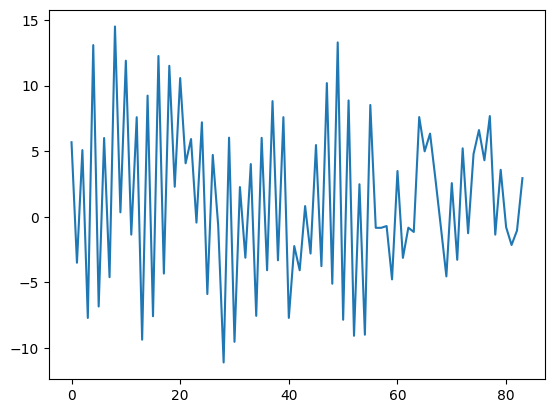

In [88]:
f0 = fun(x0, len(cams), points_3d.shape[0], points_2d)
plt.plot(f0)
f0

In [89]:
from scipy.optimize import least_squares

res = least_squares(fun, x0, verbose=2, x_scale='jac', ftol=1e-4, method='trf',  # , loss='linear',
                    args=(len(cams), points_3d.shape[0], points_2d))

[[0.999 -0.049 -0.008]
 [0.049 0.998 -0.028]
 [0.009 0.028 1.000]] [-0.007 -0.007 -2.506]
[[0.998 -0.055 0.005]
 [0.055 0.998 -0.041]
 [-0.003 0.041 0.999]] [-0.091 -0.005 -2.506]
[[0.999 -0.045 -0.004]
 [0.045 0.998 -0.032]
 [0.005 0.032 0.999]] [-0.196 -0.016 -2.505]
[[0.999 -0.049 -0.008]
 [0.049 0.998 -0.028]
 [0.009 0.028 1.000]] [-0.007 -0.007 -2.506]
[[0.998 -0.055 0.005]
 [0.055 0.998 -0.041]
 [-0.003 0.041 0.999]] [-0.091 -0.005 -2.506]
[[0.999 -0.045 -0.004]
 [0.045 0.998 -0.032]
 [0.005 0.032 0.999]] [-0.196 -0.016 -2.505]
[[0.999 -0.049 -0.008]
 [0.049 0.998 -0.028]
 [0.009 0.028 1.000]] [-0.007 -0.007 -2.506]
[[0.998 -0.055 0.005]
 [0.055 0.998 -0.041]
 [-0.003 0.041 0.999]] [-0.091 -0.005 -2.506]
[[0.999 -0.045 -0.004]
 [0.045 0.998 -0.032]
 [0.005 0.032 0.999]] [-0.196 -0.016 -2.505]
[[0.999 -0.049 -0.008]
 [0.049 0.998 -0.028]
 [0.009 0.028 1.000]] [-0.007 -0.007 -2.506]
[[0.998 -0.055 0.005]
 [0.055 0.998 -0.041]
 [-0.003 0.041 0.999]] [-0.091 -0.005 -2.506]
[[0.999 -0

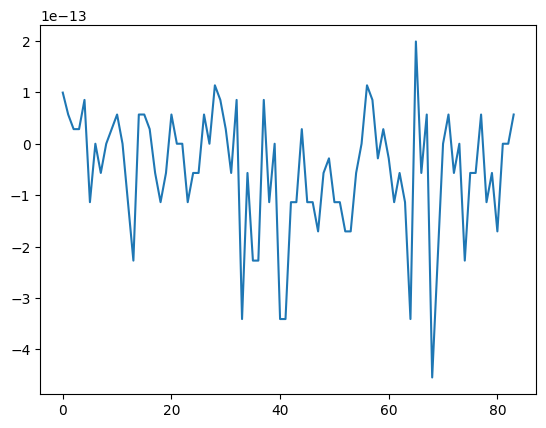

In [90]:
plt.plot(res.fun)

In [91]:
res.x

array([-0.016, -0.007, 0.000, -0.090, 0.004, -4.547, -0.016, -0.007,
       0.000, -0.175, 0.004, -4.548, -0.016, -0.007, 0.000, -0.261, 0.004,
       -4.548, -0.547, -0.313, -2.821, -0.551, -0.269, -1.968, -0.502,
       0.540, -2.865, -0.506, 0.583, -2.011, 0.307, -0.357, -2.815, 0.303,
       -0.313, -1.961, 0.351, 0.495, -2.859, 0.347, 0.539, -2.005, -0.527,
       0.135, -2.416, 0.327, 0.091, -2.410, -0.122, -0.313, -2.391,
       -0.078, 0.539, -2.435, -0.098, 0.091, -2.840, -0.102, 0.135,
       -1.986])

In [92]:
camera_params

array([0.035, -0.001, 0.052, 0.000, 0.000, -2.500, 0.035, -0.001, 0.052,
       -0.100, -0.005, -2.500, 0.035, -0.001, 0.052, -0.200, -0.010,
       -2.500])

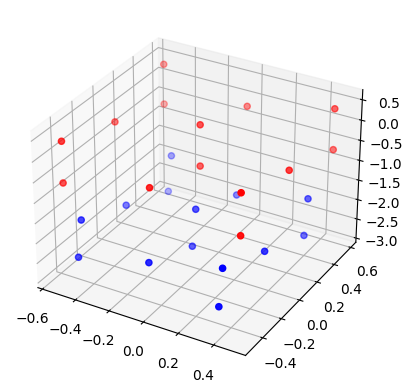

In [93]:
result_3d_points = res.x[len(cams)*6:].reshape((N, 3))
# plot these in 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result_3d_points[:, 0], result_3d_points[:, 1],
           result_3d_points[:, 2], c='b', marker='o')
# points_3d on top also
ax.scatter(points_3d[:, 0], points_3d[:, 1],
           points_3d[:, 2], c='r', marker='o')

In [94]:
result_3d_points

array([[-0.547, -0.313, -2.821],
       [-0.551, -0.269, -1.968],
       [-0.502, 0.540, -2.865],
       [-0.506, 0.583, -2.011],
       [0.307, -0.357, -2.815],
       [0.303, -0.313, -1.961],
       [0.351, 0.495, -2.859],
       [0.347, 0.539, -2.005],
       [-0.527, 0.135, -2.416],
       [0.327, 0.091, -2.410],
       [-0.122, -0.313, -2.391],
       [-0.078, 0.539, -2.435],
       [-0.098, 0.091, -2.840],
       [-0.102, 0.135, -1.986]])

In [95]:
points_3d / result_3d_points

array([[0.914, 1.598, 0.177],
       [0.908, 1.857, -0.254],
       [0.995, 0.927, 0.175],
       [0.987, 0.857, -0.249],
       [1.630, 1.400, 0.178],
       [1.652, 1.595, -0.255],
       [1.423, 1.010, 0.175],
       [1.440, 0.928, -0.249],
       [0.949, 0.000, -0.000],
       [1.529, 0.000, -0.000],
       [-0.000, 1.596, -0.000],
       [-0.000, 0.927, -0.000],
       [-0.000, 0.000, 0.176],
       [-0.000, 0.000, -0.252]])